1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


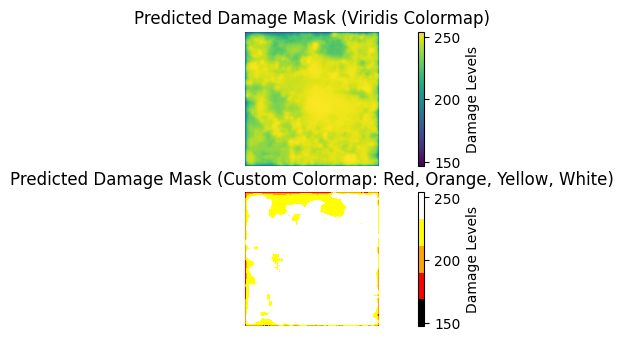

In [19]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
import random

model = load_model('disaster_damage_assessment_model.h5')

IMG_HEIGHT, IMG_WIDTH = 256, 256

window = tk.Tk()
window.title("CNN-Based Disaster Damage Assessment Using Satellite Images")
window.geometry("1300x900")
window.config(bg='#212F3C')

title_label = tk.Label(window, text="DISASTER DAMAGE ASSESSMENT", font=("OCR A Extended", 18), fg="cyan", bg='#212F3C')
title_label.pack(pady=10)

frame_top = tk.Frame(window, bg='#212F3C')
frame_top.pack(pady=10)

frame_bottom = tk.Frame(window, bg='#212F3C')
frame_bottom.pack(pady=10)

canvas_pre = tk.Canvas(frame_top, width=256, height=256, bg='black')
canvas_pre.grid(row=0, column=0, padx=10, pady=10)

canvas_post = tk.Canvas(frame_top, width=256, height=256, bg='black')
canvas_post.grid(row=0, column=1, padx=10, pady=10)

canvas_mask = tk.Canvas(frame_top, width=256, height=256, bg='black')
canvas_mask.grid(row=0, column=2, padx=10, pady=10)

pre_image = None
post_image = None

def upload_pre_image():
    global pre_image
    file_path = filedialog.askopenfilename()
    if file_path:
        img_pre = Image.open(file_path).resize((IMG_WIDTH, IMG_HEIGHT))
        img_pre_tk = ImageTk.PhotoImage(img_pre)
        canvas_pre.create_image(0, 0, anchor=tk.NW, image=img_pre_tk)
        canvas_pre.image = img_pre_tk
        pre_image = np.array(img_pre) / 255.0

def upload_post_image():
    global post_image
    file_path = filedialog.askopenfilename()
    if file_path:
        img_post = Image.open(file_path).resize((IMG_WIDTH, IMG_HEIGHT))
        img_post_tk = ImageTk.PhotoImage(img_post)
        canvas_post.create_image(0, 0, anchor=tk.NW, image=img_post_tk)
        canvas_post.image = img_post_tk
        post_image = np.array(img_post) / 255.0

upload_pre_button = tk.Button(frame_bottom, text="Upload Pre-Disaster Image", command=upload_pre_image, font=("OCR A Extended", 12), bg="cyan", fg="black")
upload_pre_button.grid(row=0, column=0, padx=10, pady=10)

upload_post_button = tk.Button(frame_bottom, text="Upload Post-Disaster Image", command=upload_post_image, font=("OCR A Extended", 12), bg="cyan", fg="black")
upload_post_button.grid(row=0, column=1, padx=10, pady=10)

def calculate_damage_mask():
    global post_image
    if post_image is None:
        return
    input_image = np.expand_dims(post_image, axis=0)
    damage_mask = model.predict(input_image)[0]
    damage_mask = (damage_mask * 255).astype(np.uint8)
    display_damage_mask(damage_mask)
    calculate_damage_statistics(damage_mask)
    plot_damage_mask(damage_mask)

def display_damage_mask(damage_mask):
    global post_image
    if damage_mask.shape[:2] != post_image.shape[:2]:
        damage_mask = cv2.resize(damage_mask, (post_image.shape[1], post_image.shape[0]))
    post_image_uint8 = (post_image * 255).astype('uint8')
    damage_mask_colored = cv2.applyColorMap(damage_mask, cv2.COLORMAP_JET)
    overlay_image = cv2.addWeighted(post_image_uint8, 0.7, damage_mask_colored, 0.3, 0)
    overlay_pil = Image.fromarray(overlay_image)
    overlay_tk = ImageTk.PhotoImage(overlay_pil)
    canvas_mask.create_image(0, 0, anchor=tk.NW, image=overlay_tk)
    canvas_mask.image = overlay_tk

def calculate_damage_statistics(damage_mask):
    threshold = 0.5
    damage_mask_thresholded = (damage_mask > threshold).astype(np.uint8)
    total_pixels = damage_mask.size
    damaged_pixels = np.count_nonzero(damage_mask_thresholded)
    damage_percentage = (damaged_pixels / total_pixels) * 100
    if damage_percentage <= 40:
        damage_level = "Low"
        damage_cost = random.randint(100000, 200000)
    elif 40 < damage_percentage <= 70:
        damage_level = "Medium"
        damage_cost = random.randint(400000, 500000)
    else:
        damage_level = "High"
        damage_cost = random.randint(600000, 800000)
    damage_level_label.config(text=f"Damage Level: {damage_level}")
    damage_cost_label.config(text=f"Estimated Cost: ₹{damage_cost} LAKHS")

def plot_damage_mask(damage_mask):
    plt.figure(figsize=(10, 8))
    plt.subplot(4, 1, 3)
    plt.title('Predicted Damage Mask (Viridis Colormap)', fontsize=12)
    plt.imshow(damage_mask, cmap='viridis')
    plt.colorbar(label='Damage Levels')
    plt.axis('off')
    plt.subplot(4, 1, 4)
    plt.title('Predicted Damage Mask (Custom Colormap: Red, Orange, Yellow, White)', fontsize=12)
    custom_cmap = plt.cm.colors.ListedColormap(['black', 'red', 'orange', 'yellow', 'white'])
    plt.imshow(damage_mask, cmap=custom_cmap)
    plt.colorbar(label='Damage Levels')
    plt.axis('off')
    plt.show()

damage_level_label = tk.Label(frame_bottom, text="Damage Percentage: ", font=("OCR A Extended", 12), bg='#212F3C', fg="cyan")
damage_level_label.grid(row=1, column=0, padx=10, pady=10)

damage_cost_label = tk.Label(frame_bottom, text="Estimated Cost: ", font=("OCR A Extended", 12), bg='#212F3C', fg="cyan")
damage_cost_label.grid(row=1, column=1, padx=10, pady=10)

predict_button = tk.Button(frame_bottom, text="Assess Damage", command=calculate_damage_mask, font=("OCR A Extended", 12), bg="red", fg="white")
predict_button.grid(row=0, column=2, padx=10, pady=10)
signature_label = tk.Label(window, text="By Inbavel S and Jenita Anjali A S", font=("OCR A Extended", 12), fg="cyan", bg='#212F3C')
signature_label.pack(side=tk.BOTTOM, pady=10)
window.mainloop()
